# Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context
### 授课老师：Yamada
# 1 前言
## 1.1课程回顾


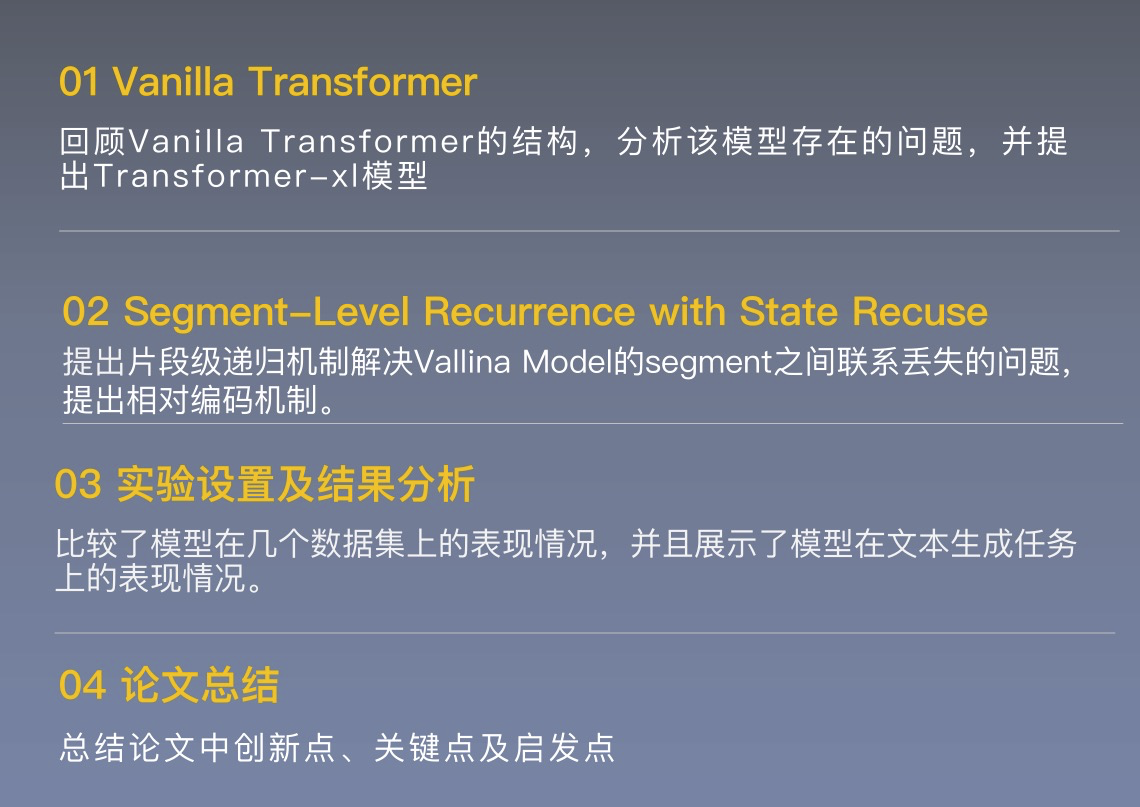

# 1.2 本课知识树
<img src="images/WechatIMG1.jpeg"  width="300" height="500" align="left"  />
<img src="images/WechatIMG3.jpeg"  width="600" height="800" align="right" />

# 2 准备工作
## 2.1项目环境配置



* Python3.7
* jupyter notebook
* torch           1.2.0+cu92
* torchsummary    1.5.1
* itertools     2.2.2+




# 2.2 数据集下载
　　 #wget --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip
    #unzip -q wikitext-103-v1.zip
    #cd wikitext-103
    #mv wiki.train.tokens train.txt
    #mv wiki.valid.tokens valid.txt
    #mv wiki.test.tokens test.txt

# 3 项目代码结构（pycharm中演示）

# 4 算法模块及细节（jupyter和pycharm中演示）

# ===========构建vocab=============

In [21]:
import os
from collections import Counter, OrderedDict

import torch
import os, sys
import glob

import numpy as np

In [22]:

class Vocab(object):
    def __init__(self, special=[], min_freq=0, max_size=None, lower_case=True,
                 delimiter=None, vocab_file=None):
        self.counter = Counter()
        self.special = special
        self.min_freq = min_freq
        self.max_size = max_size
        self.lower_case = lower_case
        self.delimiter = delimiter
        self.vocab_file = vocab_file
    
    #<---------对句子进行token split并且添加<eos>---->
    def tokenize(self, line, add_eos=False, add_double_eos=False):
        line = line.strip()
        # convert to lower case
        if self.lower_case:
            line = line.lower()

        # empty delimiter '' will evaluate False
        if self.delimiter == '':
            symbols = line
        else:
            symbols = line.split(self.delimiter)

        if add_double_eos: # lm1b
            return ['<S>'] + symbols + ['<S>']
        elif add_eos:
            return symbols + ['<eos>']
        else:
            return symbols

    #<---------读取语料---->
    def count_file(self, path, verbose=False, add_eos=False):
        if verbose: print('counting file {} ...'.format(path))
        assert os.path.exists(path)

        sents = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos)
                self.counter.update(symbols)
                sents.append(symbols)

        return sents

    def count_sents(self, sents, verbose=False):
        """
            sents : a list of sentences, each a list of tokenized symbols
        """
        if verbose: print('counting {} sents ...'.format(len(sents)))
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            self.counter.update(symbols)

    def _build_from_file(self, vocab_file):
        self.idx2sym = []
        self.sym2idx = OrderedDict()

        with open(vocab_file, 'r', encoding='utf-8') as f:
            for line in f:
                symb = line.strip().split()[0]
                self.add_symbol(symb)
        self.unk_idx = self.sym2idx['<UNK>']
    
    #<---------构建vocab---->
    #<词典个数267735>
    def build_vocab(self):
        if self.vocab_file:
            print('building vocab from {}'.format(self.vocab_file))
            self._build_from_file(self.vocab_file)
            print('final vocab size {}'.format(len(self)))
        else:
            print('building vocab with min_freq={}, max_size={}'.format(
                self.min_freq, self.max_size))
            self.idx2sym = []
            self.sym2idx = OrderedDict()

            for sym in self.special:
                self.add_special(sym)

            for sym, cnt in self.counter.most_common(self.max_size):
                if cnt < self.min_freq: break
                self.add_symbol(sym)

            print('final vocab size {} from {} unique tokens'.format(
                len(self), len(self.counter)))
    
    
    #<---------将token转换成index---->
    #<1801349句>
    def encode_file(self, path, ordered=False, verbose=False, add_eos=True,
            add_double_eos=False):
        if verbose: print('encoding file {} ...'.format(path))
        assert os.path.exists(path)
        encoded = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos,
                    add_double_eos=add_double_eos)
                encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            #<------—-把所有的句子拼接成一句-------->
            encoded = torch.cat(encoded)

        return encoded

    def encode_sents(self, sents, ordered=False, verbose=False):
        if verbose: print('encoding {} sents ...'.format(len(sents)))
        encoded = []
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def add_special(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1
            setattr(self, '{}_idx'.format(sym.strip('<>')), self.sym2idx[sym])

    def add_symbol(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1

    def get_sym(self, idx):
        assert 0 <= idx < len(self), 'Index {} out of range'.format(idx)
        return self.idx2sym[idx]

    def get_idx(self, sym):
        if sym in self.sym2idx:
            return self.sym2idx[sym]
        else:
            # print('encounter unk {}'.format(sym))
            assert '<eos>' not in sym
            assert hasattr(self, 'unk_idx')
            return self.sym2idx.get(sym, self.unk_idx)

    def get_symbols(self, indices):
        return [self.get_sym(idx) for idx in indices]

    def get_indices(self, symbols):
        return [self.get_idx(sym) for sym in symbols]

    def convert_to_tensor(self, symbols):
        return torch.LongTensor(self.get_indices(symbols))

    def convert_to_sent(self, indices, exclude=None):
        if exclude is None:
            return ' '.join([self.get_sym(idx) for idx in indices])
        else:
            return ' '.join([self.get_sym(idx) for idx in indices if idx not in exclude])

    def __len__(self):
        return len(self.idx2sym)


# ==============构建data_utils=============

In [23]:
class LMOrderedIterator(object):
    def __init__(self, data, bsz, bptt, device='cpu', ext_len=None):
        """
            data -- LongTensor -- the LongTensor is strictly ordered
        """
        #bsz=60
        self.bsz = bsz
        #bptt=150
        self.bptt = bptt
        #ext_len=0
        self.ext_len = ext_len if ext_len is not None else 0

        self.device = device
        
        #n_step=1720450
        # Work out how cleanly we can divide the dataset into bsz parts.
        self.n_step = data.size(0) // bsz

        # Trim off any extra elements that wouldn't cleanly fit (remainders).
        data = data.narrow(0, 0, self.n_step * bsz)

        # Evenly divide the data across the bsz batches.
        self.data = data.view(bsz, -1).t().contiguous().to(device)

        # Number of mini-batches
        self.n_batch = (self.n_step + self.bptt - 1) // self.bptt

    def get_batch(self, i, bptt=None):
        if bptt is None: bptt = self.bptt
        #seq_len(148/146)
        seq_len = min(bptt, self.data.size(0) - 1 - i)
        
        #(152/300/446)
        end_idx = i + seq_len
        beg_idx = max(0, i - self.ext_len)

        data = self.data[beg_idx:end_idx]
        target = self.data[i+1:i+1+seq_len]

        return data, target, seq_len

    def get_fixlen_iter(self, start=0):
        for i in range(start, self.data.size(0) - 1, self.bptt):
            yield self.get_batch(i)

    def get_varlen_iter(self, start=0, std=5, min_len=5, max_deviation=3):
        #max_len=150+3*5=165
        max_len = self.bptt + max_deviation * std
        i = start
        while True:
            #bptt=150
            bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
            #bptt=152/148/146
            bptt = min(max_len, max(min_len, int(np.random.normal(bptt, std))))
            data, target, seq_len = self.get_batch(i, bptt)
            i += seq_len
            yield data, target, seq_len
            # if i >= self.data.size(0) - 2:
            if i >= 1000:

                break

    def __iter__(self):
        return self.get_fixlen_iter()

In [24]:
class Corpus(object):
    def __init__(self, path, dataset, *args, **kwargs):
        self.dataset = dataset
        self.vocab = Vocab(*args, **kwargs)

        if self.dataset == 'wt103':
            self.vocab.count_file(os.path.join(path, 'train.txt'))
       
        self.vocab.build_vocab()

        if self.dataset in ['ptb', 'wt2', 'wt103']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True)
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True)

    def get_iterator(self, split, *args, **kwargs):
        if split == 'train':
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(self.train, *args, **kwargs)
        elif split in ['valid', 'test']:
            data = self.valid if split == 'valid' else self.test
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(data, *args, **kwargs)

        return data_iter

In [25]:
def get_lm_corpus(datadir, dataset):
    fn = os.path.join(datadir, 'cache.pt')
    if os.path.exists(fn):
        print('Loading cached dataset...')
        corpus = torch.load(fn)
    else:
        print('Producing dataset {}...'.format(dataset))
        kwargs = {}
        if dataset in ['wt103', 'wt2']:
            kwargs['special'] = ['<eos>']
            kwargs['lower_case'] = False

        corpus = Corpus(datadir, dataset, **kwargs)
        torch.save(corpus, fn)

    return corpus

# ==========新建model文件mem_transformer.py===========

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# positional encoding类

In [27]:
class PositionalEmbedding(nn.Module):
    def __init__(self, demb):
        super(PositionalEmbedding, self).__init__()

        self.demb = demb

        inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, pos_seq, bsz=None):
        sinusoid_inp = torch.ger(pos_seq, self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)

        if bsz is not None:
            return pos_emb[:,None,:].expand(-1, bsz, -1)
        else:
            return pos_emb[:,None,:]

# Feed-Forward Network类

In [28]:
class PositionwiseFF(nn.Module):
    def __init__(self, d_model, d_inner, dropout, pre_lnorm=False):
        super(PositionwiseFF, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout

        self.CoreNet = nn.Sequential(
            nn.Linear(d_model, d_inner), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_inner, d_model),
            nn.Dropout(dropout),
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.pre_lnorm = pre_lnorm

    def forward(self, inp):
        if self.pre_lnorm:
            ##### layer normalization + positionwise feed-forward
            core_out = self.CoreNet(self.layer_norm(inp))

            ##### residual connection
            output = core_out + inp
        else:
            ##### positionwise feed-forward
            core_out = self.CoreNet(inp)

            ##### residual connection + layer normalization
            output = self.layer_norm(inp + core_out)

        return output

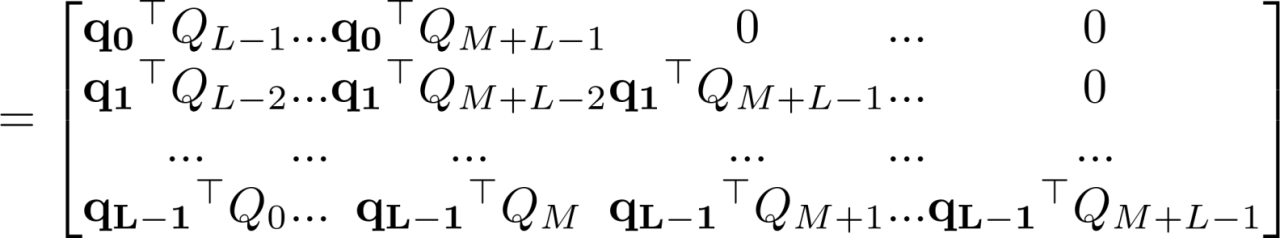

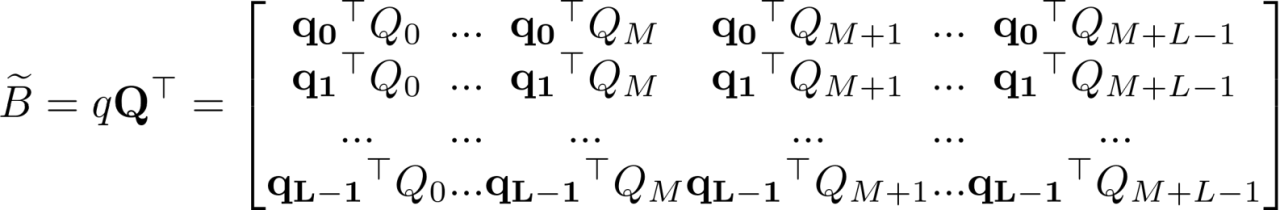

# RelmultiHeadAttn(主要实现shift功能)

In [29]:
class RelMultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0,
                 tgt_len=None, ext_len=None, mem_len=None, pre_lnorm=False):
        super(RelMultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout

        self.qkv_net = nn.Linear(d_model, 3 * n_head * d_head, bias=False)

        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.scale = 1 / (d_head ** 0.5)

        self.pre_lnorm = pre_lnorm


    def _rel_shift(self, x, zero_triu=False):
        #x:[qlen,rlen,bsz,heads]=[146,296,60,10]
        
        #zero_pad:[146,1,60,10]
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        #x_padded:[146,297,60,10]
        x_padded = torch.cat([zero_pad, x], dim=1)
        
        #x_padded:[297,146,60,10]
        x_padded = x_padded.view(x.size(1) + 1, x.size(0), *x.size()[2:])

        x = x_padded[1:].view_as(x)

        if zero_triu:
            ones = torch.ones((x.size(0), x.size(1)))
            x = x * torch.tril(ones, x.size(1) - x.size(0))[:,:,None,None]

        return x

    def forward(self, w, r, attn_mask=None, mems=None):
        raise NotImplementedError

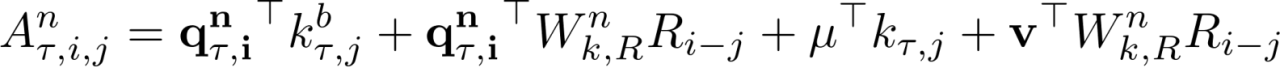

# RelPartialLearnableMultiHeadAttn类，实现self-attention的类

In [30]:
class RelPartialLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelPartialLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

        self.r_net = nn.Linear(self.d_model, self.n_head * self.d_head, bias=False)

    def forward(self, w, r, r_w_bias, r_r_bias, attn_mask=None, mems=None):
        #w表示embedding,r代表pistional encoding
        #qlen=146 rlen=296 bsz=60
        qlen, rlen, bsz = w.size(0), r.size(0), w.size(1)
        
        #判断memory是否为none
        if mems is not None:
            cat = torch.cat([mems, w], 0)
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(cat))
            else:
                w_heads = self.qkv_net(cat)
            r_head_k = self.r_net(r)
            
            #这里的qkv没有单独作为输入，而是将embedding和Wqkv矩阵相乘之后分段
            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)
            w_head_q = w_head_q[-qlen:]
        else:
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(w))
            else:
                w_heads = self.qkv_net(w)
            r_head_k = self.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

        klen = w_head_k.size(0)
        
        #multihead的操作
        #n_head=10 d_head=41
        w_head_q = w_head_q.view(qlen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_k = w_head_k.view(klen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_v = w_head_v.view(klen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head

        r_head_k = r_head_k.view(rlen, self.n_head, self.d_head)                # qlen x n_head x d_head

        # w_head_q=q       r_w_bias=Ut  w_head_k=k
        # (w_head_q+r_w_bias)*k=qk+k*Ut
        # AC=[146,296,60,10]
        #### compute attention score
        rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
        AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head

        # w_head_q=q       r_r_bias=Vt
        # (w_head_q+r_r_bias)*r_head_k=(q+Vt)*WRi-j
        # BD=[146,296,60,10]
        rr_head_q = w_head_q + r_r_bias
        BD = torch.einsum('ibnd,jnd->ijbn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
        BD = self._rel_shift(BD)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[None,:,:,None], -float('inf')).type_as(attn_score)
            elif attn_mask.dim() == 3:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[:,:,:,None], -float('inf')).type_as(attn_score)

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ijbn,jbnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)
        #[146,60,410]
        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = w + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(w + attn_out)

        return output

# RelPartialLearnableDecoderLayer类，相当于sublayer

In [31]:
class RelPartialLearnableDecoderLayer(nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout,
                 **kwargs):
        super(RelPartialLearnableDecoderLayer, self).__init__()
        
        #self-attention模块
        self.dec_attn = RelPartialLearnableMultiHeadAttn(n_head, d_model,
                            d_head, dropout, **kwargs)
        #feed-forward network模块
        self.pos_ff = PositionwiseFF(d_model, d_inner, dropout, 
                                     pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, r, r_w_bias, r_r_bias, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, r, r_w_bias, r_r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output

# AdaptiveEmbedding类

In [32]:
class AdaptiveEmbedding(nn.Module):
    def __init__(self, n_token, d_embed, d_proj, cutoffs, div_val=1, 
                 sample_softmax=False):
        super(AdaptiveEmbedding, self).__init__()

        self.n_token = n_token
        self.d_embed = d_embed

        self.cutoffs = cutoffs + [n_token]
        self.div_val = div_val
        self.d_proj = d_proj

        self.emb_scale = d_proj ** 0.5

        self.cutoff_ends = [0] + self.cutoffs

        self.emb_layers = nn.ModuleList()
        self.emb_projs = nn.ParameterList()
        if div_val == 1:
            self.emb_layers.append(
                nn.Embedding(n_token, d_embed, sparse=sample_softmax>0)
            )
            if d_proj != d_embed:
                self.emb_projs.append(nn.Parameter(torch.Tensor(d_proj, d_embed)))
        else:
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i+1]
                d_emb_i = d_embed // (div_val ** i)
                self.emb_layers.append(nn.Embedding(r_idx-l_idx, d_emb_i))
                self.emb_projs.append(nn.Parameter(torch.Tensor(d_proj, d_emb_i)))

    def forward(self, inp):
        if self.div_val == 1:
            embed = self.emb_layers[0](inp)
            if self.d_proj != self.d_embed:
                embed  = F.linear(embed, self.emb_projs[0])
        else:
            param = next(self.parameters())
            inp_flat = inp.view(-1)
            emb_flat = torch.zeros([inp_flat.size(0), self.d_proj], 
                dtype=param.dtype, device=param.device)
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]

                mask_i = (inp_flat >= l_idx) & (inp_flat < r_idx)
                indices_i = mask_i.nonzero().squeeze()

                if indices_i.numel() == 0:
                    continue

                inp_i = inp_flat.index_select(0, indices_i) - l_idx
                emb_i = self.emb_layers[i](inp_i)
                emb_i = F.linear(emb_i, self.emb_projs[i])

                emb_flat.index_copy_(0, indices_i, emb_i)

            embed = emb_flat.view(*inp.size(), self.d_proj)

        embed.mul_(self.emb_scale)

        return embed

# 模型主类MemTransformerLM

In [33]:
class MemTransformerLM(nn.Module):
    def __init__(self, n_token, n_layer, n_head, d_model, d_head, d_inner,
                 dropout, dropatt, tie_weight=True, d_embed=None, 
                 div_val=1, tie_projs=[False], pre_lnorm=False,
                 tgt_len=None, ext_len=None, mem_len=None, 
                 cutoffs=[], adapt_inp=False,
                 same_length=False, attn_type=0, clamp_len=-1, 
                 sample_softmax=-1):
        super(MemTransformerLM, self).__init__()
        self.n_token = n_token

        d_embed = d_model if d_embed is None else d_embed
        self.d_embed = d_embed
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head

        self.word_emb = AdaptiveEmbedding(n_token, d_embed, d_model, cutoffs, 
                                          div_val=div_val)

        self.drop = nn.Dropout(dropout)

        self.n_layer = n_layer
        
        #tgt_len 需要predict的token的数目
        self.tgt_len = tgt_len
        #mem_len memory的长度
        self.mem_len = mem_len
        #ext_len 是extended content的长度
        self.ext_len = ext_len
        self.max_klen = tgt_len + ext_len + mem_len
        
        #定义模型的类型 0代表trans-xl
        self.attn_type = attn_type

        self.layers = nn.ModuleList()
        if attn_type == 0: # the default attention
            for i in range(n_layer):
                self.layers.append(
                    RelPartialLearnableDecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len,
                        dropatt=dropatt, pre_lnorm=pre_lnorm)
                )

        self.sample_softmax = sample_softmax
        # use sampled softmax
        if sample_softmax > 0:
            self.out_layer = nn.Linear(d_model, n_token)
            if tie_weight:
                self.out_layer.weight = self.word_emb.weight
            self.tie_weight = tie_weight
            self.sampler = LogUniformSampler(n_token, sample_softmax)

        # use adaptive softmax (including standard softmax)
        else:
            self.crit = ProjectedAdaptiveLogSoftmax(n_token, d_embed, d_model, 
                                                    cutoffs, div_val=div_val)

            if tie_weight:
                for i in range(len(self.crit.out_layers)):
                    self.crit.out_layers[i].weight = self.word_emb.emb_layers[i].weight

            if tie_projs:
                for i, tie_proj in enumerate(tie_projs):
                    if tie_proj and div_val == 1 and d_model != d_embed:
                        self.crit.out_projs[i] = self.word_emb.emb_projs[0]
                    elif tie_proj and div_val != 1:
                        self.crit.out_projs[i] = self.word_emb.emb_projs[i]

        self.same_length = same_length
        self.clamp_len = clamp_len

        self._create_params()

    def backward_compatible(self):
        self.sample_softmax = -1

    def _create_params(self):
        if self.attn_type == 0: # default attention
            self.pos_emb = PositionalEmbedding(self.d_model)
            self.r_w_bias = nn.Parameter(torch.Tensor(self.n_head, self.d_head))
            self.r_r_bias = nn.Parameter(torch.Tensor(self.n_head, self.d_head))
        

    def reset_length(self, tgt_len, ext_len, mem_len):
        self.tgt_len = tgt_len
        self.mem_len = mem_len
        self.ext_len = ext_len

    def init_mems(self):
        if self.mem_len > 0:
            mems = []
            param = next(self.parameters())
            for i in range(self.n_layer+1):
                empty = torch.empty(0, dtype=param.dtype, device=param.device)
                mems.append(empty)

            return mems
        else:
            return None

    def _update_mems(self, hids, mems, qlen, mlen):
        # does not deal with None
        if mems is None: return None

        # mems is not None
        assert len(hids) == len(mems), 'len(hids) != len(mems)'

        # There are `mlen + qlen` steps that can be cached into mems
        # For the next step, the last `ext_len` of the `qlen` tokens
        # will be used as the extended context. Hence, we only cache
        # the tokens from `mlen + qlen - self.ext_len - self.mem_len`
        # to `mlen + qlen - self.ext_len`.
        with torch.no_grad():
            new_mems = []
            #146+max(0,150)
            end_idx = mlen + max(0, qlen - 0 - self.ext_len)
            #max(0,296-150)
            beg_idx = max(0, end_idx - self.mem_len)
            #i对应于第几层sublayer
            for i in range(len(hids)):

                cat = torch.cat([mems[i], hids[i]], dim=0)
                new_mems.append(cat[beg_idx:end_idx].detach())

        return new_mems

    def _forward(self, dec_inp, mems=None):
        #146，60
        qlen, bsz = dec_inp.size()

        word_emb = self.word_emb(dec_inp)

        mlen = mems[0].size(0) if mems is not None else 0
        #klen=150+146=296
        klen = mlen + qlen
        if self.same_length:
            all_ones = word_emb.new_ones(qlen, klen)
            mask_len = klen - self.mem_len
            if mask_len > 0:
                mask_shift_len = qlen - mask_len
            else:
                mask_shift_len = qlen
            dec_attn_mask = (torch.triu(all_ones, 1+mlen)
                    + torch.tril(all_ones, -mask_shift_len)).byte()[:, :, None] # -1
        else:
            dec_attn_mask = torch.triu(
                word_emb.new_ones(qlen, klen), diagonal=1+mlen).byte()[:,:,None]

        hids = []
        if self.attn_type == 0: # default
            pos_seq = torch.arange(klen-1, -1, -1.0, device=word_emb.device, 
                                   dtype=word_emb.dtype)
            if self.clamp_len > 0:
                pos_seq.clamp_(max=self.clamp_len)
            
            #[296,1,60]
            pos_emb = self.pos_emb(pos_seq)

            core_out = self.drop(word_emb)
            pos_emb = self.drop(pos_emb)

            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                mems_i = None if mems is None else mems[i]
                core_out = layer(core_out, pos_emb, self.r_w_bias,
                        self.r_r_bias, dec_attn_mask=dec_attn_mask, mems=mems_i)
                hids.append(core_out)
        
        

        core_out = self.drop(core_out)

        new_mems = self._update_mems(hids, mems, mlen, qlen)

        return core_out, new_mems

    def forward(self, data, target, *mems):
        # nn.DataParallel does not allow size(0) tensors to be broadcasted.
        # So, have to initialize size(0) mems inside the model forward.
        # Moreover, have to return new_mems to allow nn.DataParallel to piece
        # them together.
        if not mems: mems = self.init_mems()

        tgt_len = target.size(0)
        hidden, new_mems = self._forward(data, mems=mems)

        pred_hid = hidden[-tgt_len:]
        if self.sample_softmax > 0 and self.training:
            assert self.tie_weight
            logit = sample_logits(self.word_emb,
                self.out_layer.bias, target, pred_hid, self.sampler)
            loss = -F.log_softmax(logit, -1)[:, :, 0]
        else:
            loss = self.crit(pred_hid.view(-1, pred_hid.size(-1)), target.view(-1))
            loss = loss.view(tgt_len, -1)

        if new_mems is None:
            return [loss]
        else:
            return [loss] + new_mems

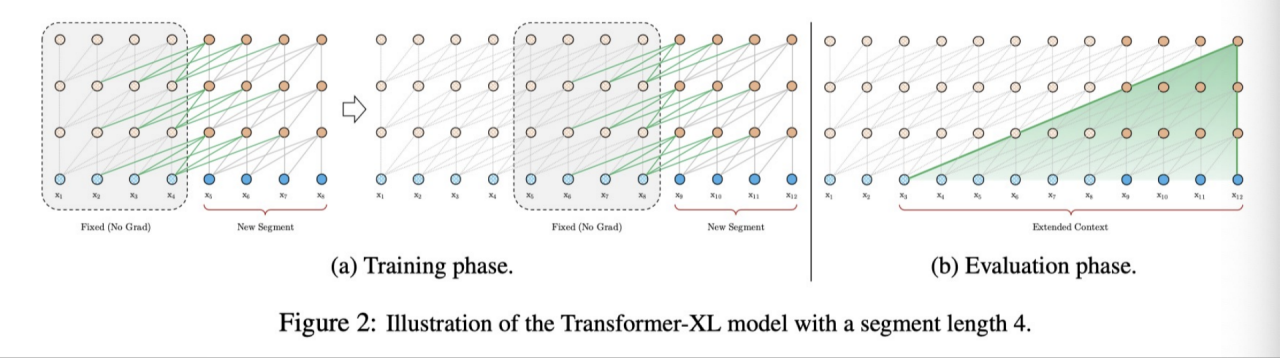

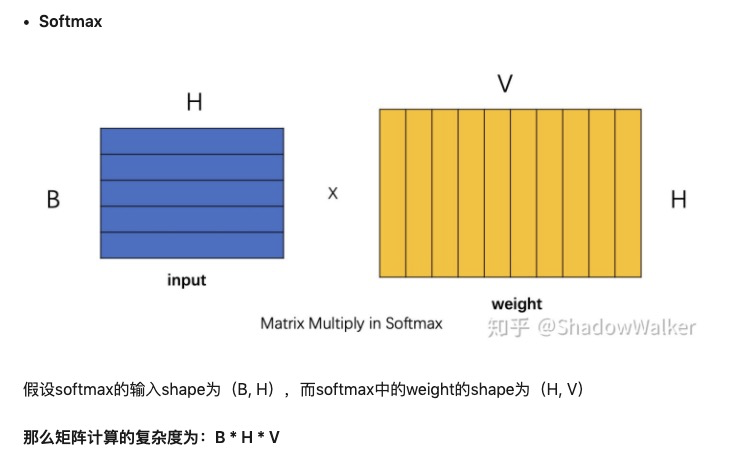

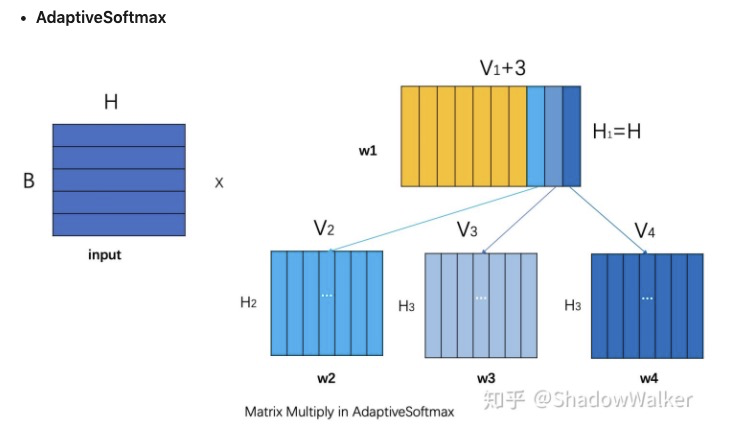

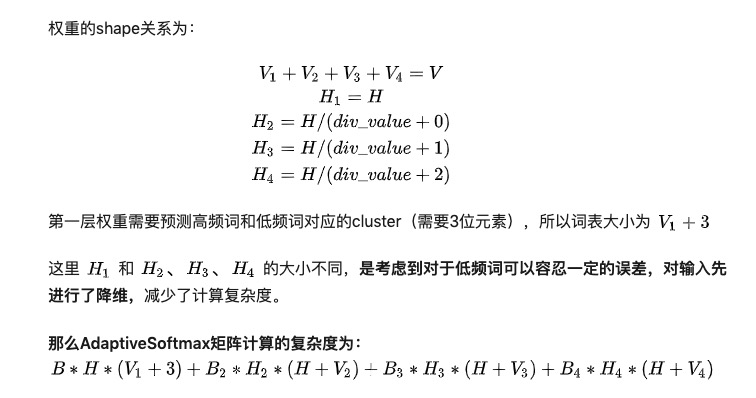

# Adaptive softmax

In [34]:
from collections import defaultdict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# CUDA_MAJOR = int(torch.version.cuda.split('.')[0])
# CUDA_MINOR = int(torch.version.cuda.split('.')[1])

class ProjectedAdaptiveLogSoftmax(nn.Module):
    def __init__(self, n_token, d_embed, d_proj, cutoffs, div_val=1,
                 keep_order=False):
        super(ProjectedAdaptiveLogSoftmax, self).__init__()
        
        #n_token代表词典里的词语的个数
        self.n_token = n_token
        #embedding纬度 410
        self.d_embed = d_embed
        #410
        self.d_proj = d_proj
        
        #[20000,40000,200000,267735]
        self.cutoffs = cutoffs + [n_token]
        #[0,20000,40000,200000,267735]
        self.cutoff_ends = [0] + self.cutoffs
        #div_val=1
        self.div_val = div_val
        
        #20000
        self.shortlist_size = self.cutoffs[0]
        #3
        self.n_clusters = len(self.cutoffs) - 1
        #20003
        self.head_size = self.shortlist_size + self.n_clusters

        if self.n_clusters > 0:
            self.cluster_weight = nn.Parameter(torch.zeros(self.n_clusters, self.d_embed))
            self.cluster_bias = nn.Parameter(torch.zeros(self.n_clusters))
        
        #后面矩阵
        self.out_layers = nn.ModuleList()
        #前面矩阵
        self.out_projs = nn.ParameterList()

        if div_val == 1:
            for i in range(len(self.cutoffs)):
                if d_proj != d_embed:
                    self.out_projs.append(
                        nn.Parameter(torch.Tensor(d_proj, d_embed))
                    )
                else:
                    self.out_projs.append(None)

            self.out_layers.append(nn.Linear(d_embed, n_token))
        else:
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i+1]
                d_emb_i = d_embed // (div_val ** i)

                self.out_projs.append(
                    nn.Parameter(torch.Tensor(d_proj, d_emb_i))
                )

                self.out_layers.append(nn.Linear(d_emb_i, r_idx-l_idx))

        self.keep_order = keep_order

    def _compute_logit(self, hidden, weight, bias, proj):
        #映射成前面矩阵
        if proj is None:
            logit = F.linear(hidden, weight, bias=bias)
        else:
            # if CUDA_MAJOR <= 9 and CUDA_MINOR <= 1:
            proj_hid = F.linear(hidden, proj.t().contiguous())
            logit = F.linear(proj_hid, weight, bias=bias)
            # else:
            #     logit = torch.einsum('bd,de,ev->bv', (hidden, proj, weight.t()))
            #     if bias is not None:
            #         logit = logit + bias

        return logit

    def forward(self, hidden, target, keep_order=False):
        '''
            hidden :: [len*bsz x d_proj]
            target :: [len*bsz]
        '''

        if hidden.size(0) != target.size(0):
            raise RuntimeError('Input and target should have the same size '
                               'in the batch dimension.')

        if self.n_clusters == 0:
            logit = self._compute_logit(hidden, self.out_layers[0].weight,
                                        self.out_layers[0].bias, self.out_projs[0])
            nll = -F.log_softmax(logit, dim=-1) \
                    .gather(1, target.unsqueeze(1)).squeeze(1)
        else:
            # construct weights and biases
            weights, biases = [], []
            for i in range(len(self.cutoffs)):
                if self.div_val == 1:
                    # l_idx=0 r_idx=20000
                    l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]
                    weight_i = self.out_layers[0].weight[l_idx:r_idx]
                    bias_i = self.out_layers[0].bias[l_idx:r_idx]
                else:
                    weight_i = self.out_layers[i].weight
                    bias_i = self.out_layers[i].bias

                if i == 0:
                    #当是高频词的时候，weight和bias相加
                    weight_i = torch.cat(
                        [weight_i, self.cluster_weight], dim=0)
                    bias_i = torch.cat(
                        [bias_i, self.cluster_bias], dim=0)

                weights.append(weight_i)
                biases.append(bias_i)

            head_weight, head_bias, head_proj = weights[0], biases[0], self.out_projs[0]
            
            #hidden对应于预测 [148*60,410]
            #head_logit [148*60,20003]
            head_logit = self._compute_logit(hidden, head_weight, head_bias, head_proj)
            head_logprob = F.log_softmax(head_logit, dim=1)

            nll = torch.zeros_like(target,
                    dtype=hidden.dtype, device=hidden.device)

            offset = 0
            #[0,20000,40000,200000,267735]
            cutoff_values = [0] + self.cutoffs
            for i in range(len(cutoff_values) - 1):
                l_idx, r_idx = cutoff_values[i], cutoff_values[i + 1]

                mask_i = (target >= l_idx) & (target < r_idx)
                indices_i = mask_i.nonzero().squeeze()
                #取出当前区间范围的index

                if indices_i.numel() == 0:
                    continue
                
                #target对应的8880   target_i对应的是8309
                target_i = target.index_select(0, indices_i) - l_idx
                head_logprob_i = head_logprob.index_select(0, indices_i)

                if i == 0:
                    #target_i[:,None]=[8880,1]
                    #取出对应的target位置的logprob
                    logprob_i = head_logprob_i.gather(1, target_i[:,None]).squeeze(1)
                else:
                    weight_i, bias_i, proj_i = weights[i], biases[i], self.out_projs[i]
                    
                    #对应于低频的词，先直接计算hidden在这个区间位置的hidden_i
                    hidden_i = hidden.index_select(0, indices_i)
                    
                    #然后计算logprob
                    tail_logit_i = self._compute_logit(hidden_i, weight_i, bias_i, proj_i)
                    tail_logprob_i = F.log_softmax(tail_logit_i, dim=1)
                    
                    #head_logprob_i的倒数第i列
                    logprob_i = head_logprob_i[:, -i] \
                              + tail_logprob_i.gather(1, target_i[:,None]).squeeze(1)

                if (hasattr(self, 'keep_order') and self.keep_order) or keep_order:
                    nll.index_copy_(0, indices_i, -logprob_i)
                else:
                    nll[offset:offset+logprob_i.size(0)].copy_(-logprob_i)

                offset += logprob_i.size(0)

        return nll


# unit test

In [35]:
# import argparse

# parser = argparse.ArgumentParser(description='unit test')

# parser.add_argument('--n_layer', type=int, default=4, help='')
# parser.add_argument('--n_rel_layer', type=int, default=4, help='')
# parser.add_argument('--n_head', type=int, default=2, help='')
# parser.add_argument('--d_head', type=int, default=2, help='')
# parser.add_argument('--d_model', type=int, default=200, help='')
# parser.add_argument('--d_embed', type=int, default=200, help='')
# parser.add_argument('--d_inner', type=int, default=200, help='')
# parser.add_argument('--dropout', type=float, default=0.0, help='')
# parser.add_argument('--cuda', action='store_true', help='')
# parser.add_argument('--seed', type=int, default=1111, help='')
# parser.add_argument('--multi_gpu', action='store_true', help='')

# args = parser.parse_args()

n_layer=4
n_head=2
d_head=2
d_model=200
d_embed=200
d_inner=200
dropout=0.0
cuda=False
seed=1111
multi_gpu=False
device = torch.device("cuda" if cuda else "cpu")

B = 4
tgt_len, mem_len, ext_len = 36, 36, 0
data_len = tgt_len * 20
n_token = 10000

# import data_utils

data = torch.LongTensor(data_len*B).random_(0, n_token).to(device)
diter = LMOrderedIterator(data, B, tgt_len, device=device, ext_len=ext_len)

cutoffs = [n_token // 2]
tie_projs = [False] + [True] * len(cutoffs)

for div_val in [1, 2]:
    for d_embed in [200, 100]:
        model = MemTransformerLM(n_token, n_layer,n_head,
                        d_model, d_head, d_inner, dropout,
                        dropatt=dropout, tie_weight=True, 
                        d_embed=d_embed, div_val=div_val, 
                        tie_projs=tie_projs, pre_lnorm=True,
                        tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len, 
                        cutoffs=cutoffs, attn_type=0).to(device)

        print(sum(p.numel() for p in model.parameters()))

        mems = tuple()
        for idx, (inp, tgt, seqlen) in enumerate(diter):
            print('batch {}'.format(idx))
            out = model(inp, tgt, *mems)
            mems = out[1:]


2351009
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
1390909
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
1951009
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
1150909
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19


# ===============程序运行主文件train.py=========

In [36]:
import argparse
import time
import math
import os, sys
import itertools

import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
parser = argparse.ArgumentParser(description='PyTorch Transformer Language Model')
parser.add_argument('--data', type=str, default='../data/wikitext-103',
                    help='location of the data corpus')
parser.add_argument('--dataset', type=str, default='wt103',
                    choices=['wt103', 'lm1b', 'enwik8', 'text8'],
                    help='dataset name')
parser.add_argument('--n_layer', type=int, default=12,
                    help='number of total layers')
parser.add_argument('--n_head', type=int, default=10,
                    help='number of heads')
parser.add_argument('--d_head', type=int, default=50,
                    help='head dimension')
parser.add_argument('--d_embed', type=int, default=-1,
                    help='embedding dimension')
parser.add_argument('--d_model', type=int, default=500,
                    help='model dimension')
parser.add_argument('--d_inner', type=int, default=1000,
                    help='inner dimension in FF')
parser.add_argument('--dropout', type=float, default=0.0,
                    help='global dropout rate')
parser.add_argument('--dropatt', type=float, default=0.0,
                    help='attention probability dropout rate')
parser.add_argument('--init', default='normal', type=str,
                    help='parameter initializer to use.')
parser.add_argument('--emb_init', default='normal', type=str,
                    help='parameter initializer to use.')
parser.add_argument('--init_range', type=float, default=0.1,
                    help='parameters initialized by U(-init_range, init_range)')
parser.add_argument('--emb_init_range', type=float, default=0.01,
                    help='parameters initialized by U(-init_range, init_range)')
parser.add_argument('--init_std', type=float, default=0.02,
                    help='parameters initialized by N(0, init_std)')
parser.add_argument('--proj_init_std', type=float, default=0.01,
                    help='parameters initialized by N(0, init_std)')
parser.add_argument('--optim', default='adam', type=str,
                    choices=['adam', 'sgd', 'adagrad'],
                    help='optimizer to use.')
parser.add_argument('--lr', type=float, default=0.00025,
                    help='initial learning rate (0.00025|5 for adam|sgd)')
parser.add_argument('--mom', type=float, default=0.0,
                    help='momentum for sgd')
parser.add_argument('--scheduler', default='cosine', type=str,
                    choices=['cosine', 'inv_sqrt', 'dev_perf', 'constant'],
                    help='lr scheduler to use.')
parser.add_argument('--warmup_step', type=int, default=0,
                    help='upper epoch limit')
parser.add_argument('--decay_rate', type=float, default=0.5,
                    help='decay factor when ReduceLROnPlateau is used')
parser.add_argument('--lr_min', type=float, default=0.0,
                    help='minimum learning rate during annealing')
parser.add_argument('--clip', type=float, default=0.25,
                    help='gradient clipping')
parser.add_argument('--clip_nonemb', action='store_true',
                    help='only clip the gradient of non-embedding params')
parser.add_argument('--max_step', type=int, default=100000,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=60,
                    help='batch size')
parser.add_argument('--batch_chunk', type=int, default=1,
                    help='split batch into chunks to save memory')
parser.add_argument('--tgt_len', type=int, default=70,
                    help='number of tokens to predict')
parser.add_argument('--eval_tgt_len', type=int, default=50,
                    help='number of tokens to predict for evaluation')
parser.add_argument('--ext_len', type=int, default=0,
                    help='length of the extended context')
parser.add_argument('--mem_len', type=int, default=0,
                    help='length of the retained previous heads')
parser.add_argument('--not_tied', action='store_true',
                    help='do not tie the word embedding and softmax weights')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--adaptive', action='store_true',
                    help='use adaptive softmax')
parser.add_argument('--div_val', type=int, default=1,
                    help='divident value for adapative input and softmax')
parser.add_argument('--pre_lnorm', action='store_true',
                    help='apply LayerNorm to the input instead of the output')
parser.add_argument('--varlen', action='store_true',
                    help='use variable length')
parser.add_argument('--multi_gpu', action='store_true',
                    help='use multiple GPU')
parser.add_argument('--log-interval', type=int, default=200,
                    help='report interval')
parser.add_argument('--eval-interval', type=int, default=4000,
                    help='evaluation interval')
parser.add_argument('--work_dir', default='LM-TFM', type=str,
                    help='experiment directory.')
parser.add_argument('--restart', action='store_true',
                    help='restart training from the saved checkpoint')
parser.add_argument('--restart_dir', type=str, default='',
                    help='restart dir')
parser.add_argument('--debug', action='store_true',
                    help='run in debug mode (do not create exp dir)')
parser.add_argument('--same_length', action='store_true',
                    help='use the same attn length for all tokens')
parser.add_argument('--attn_type', type=int, default=0,
                    help='attention type. 0 for ours, 1 for Shaw et al,'
                    '2 for Vaswani et al, 3 for Al Rfou et al.')
parser.add_argument('--clamp_len', type=int, default=-1,
                    help='use the same pos embeddings after clamp_len')
parser.add_argument('--eta_min', type=float, default=0.0,
                    help='min learning rate for cosine scheduler')
parser.add_argument('--gpu0_bsz', type=int, default=-1,
                    help='batch size on gpu 0')
parser.add_argument('--max_eval_steps', type=int, default=-1,
                    help='max eval steps')
parser.add_argument('--sample_softmax', type=int, default=-1,
                    help='number of samples in sampled softmax')
parser.add_argument('--patience', type=int, default=0,
                    help='patience')
parser.add_argument('--finetune_v2', action='store_true',
                    help='finetune v2')
parser.add_argument('--finetune_v3', action='store_true',
                    help='finetune v3')
parser.add_argument('--fp16', action='store_true',
                    help='Run in pseudo-fp16 mode (fp16 storage fp32 math).')
parser.add_argument('--static-loss-scale', type=float, default=1,
                    help='Static loss scale, positive power of 2 values can '
                    'improve fp16 convergence.')
parser.add_argument('--dynamic-loss-scale', action='store_true',
                    help='Use dynamic loss scaling.  If supplied, this argument'
                    ' supersedes --static-loss-scale.')

_StoreTrueAction(option_strings=['--dynamic-loss-scale'], dest='dynamic_loss_scale', nargs=0, const=True, default=False, type=None, choices=None, help='Use dynamic loss scaling.  If supplied, this argument supersedes --static-loss-scale.', metavar=None)

In [38]:
##########打印日志#############

def create_exp_dir(dir_path, scripts_to_save=None, debug=False):
    if debug:
        print('Debug Mode : no experiment dir created')
        return functools.partial(logging, log_path=None, log_=False)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    print('Experiment dir : {}'.format(dir_path))
    if scripts_to_save is not None:
        script_path = os.path.join(dir_path, 'scripts')
        if not os.path.exists(script_path):
            os.makedirs(script_path)
        for script in scripts_to_save:
            dst_file = os.path.join(dir_path, 'scripts', os.path.basename(script))
            shutil.copyfile(script, dst_file)

    return get_logger(log_path=os.path.join(dir_path, 'log.txt'))

# 1)Load Data

In [39]:
#输入数据路径 data="../data/wikitext-103" dataset="wt103"
data="../data/wikitext-103"
dataset="wt103"
corpus = get_lm_corpus(data, dataset)
ntokens = len(corpus.vocab)
args.n_token = ntokens

eval_batch_size = 10
args.ext_len=0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tr_iter = corpus.get_iterator('train', args.batch_size, args.tgt_len,
    device=device, ext_len=args.ext_len)
va_iter = corpus.get_iterator('valid', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)
te_iter = corpus.get_iterator('test', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)

# adaptive softmax / embedding
cutoffs, tie_projs = [], [False]
args.adaptive=True
if args.adaptive:
    assert args.dataset in ['wt103', 'lm1b']
    if args.dataset == 'wt103':
        cutoffs = [20000, 40000, 200000]
        tie_projs += [True] * len(cutoffs)


NameError: name 'args' is not defined

In [42]:
seed=1111
cuda=True
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    if not cuda:
        print('WARNING: You have a CUDA device, so you should probably run with --cuda')
    else:
        torch.cuda.manual_seed_all(seed)

# Validate `--fp16` option
fp16=True
if fp16:
    if not cuda:
        print('WARNING: --fp16 requires --cuda, ignoring --fp16 option')
        fp16 = False
    else:
        try:
            from apex.fp16_utils import FP16_Optimizer
        except:
            print('WARNING: apex not installed, ignoring --fp16 option')
            fp16 = False

device = torch.device('cuda' if cuda else 'cpu')

# 2)Build the Model

In [44]:
init='normal'
init_std=0.02
def init_weight(weight):
    if init == 'uniform':
        nn.init.uniform_(weight, -init_range, init_range)
    elif init == 'normal':
        nn.init.normal_(weight, 0.0, init_std)

def init_bias(bias):
    nn.init.constant_(bias, 0.0)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            init_weight(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('AdaptiveEmbedding') != -1:
        if hasattr(m, 'emb_projs'):
            for i in range(len(m.emb_projs)):
                if m.emb_projs[i] is not None:
                    nn.init.normal_(m.emb_projs[i], 0.0, proj_init_std)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'):
            init_weight(m.weight)
    elif classname.find('ProjectedAdaptiveLogSoftmax') != -1:
        if hasattr(m, 'cluster_weight') and m.cluster_weight is not None:
            init_weight(m.cluster_weight)
        if hasattr(m, 'cluster_bias') and m.cluster_bias is not None:
            init_bias(m.cluster_bias)
        if hasattr(m, 'out_projs'):
            for i in range(len(m.out_projs)):
                if m.out_projs[i] is not None:
                    nn.init.normal_(m.out_projs[i], 0.0, proj_init_std)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 1.0, init_std)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('TransformerLM') != -1:
        if hasattr(m, 'r_emb'):
            init_weight(m.r_emb)
        if hasattr(m, 'r_w_bias'):
            init_weight(m.r_w_bias)
        if hasattr(m, 'r_r_bias'):
            init_weight(m.r_r_bias)
        if hasattr(m, 'r_bias'):
            init_bias(m.r_bias)

def update_dropout(m):
    classname = m.__class__.__name__
    if classname.find('Dropout') != -1:
        if hasattr(m, 'p'):
            m.p = dropout

def update_dropatt(m):
    if hasattr(m, 'dropatt'):
        m.dropatt.p = dropatt

restart=False
dropatt=0.0
div_val=1
pre_lnorm=True
same_length=True
attn_type=0
clamp_len=-1
sample_softmax=-1
n_layer=16
n_head=10
d_model=410
d_head=41
d_inner=2100
dropout=0.1
dropatt=0.0
tied=False
d_embed=d_model
tgt_len=150
ext_len=0
mem_len=150

if restart:
    with open(os.path.join(restart_dir, 'model.pt'), 'rb') as f:
        model = torch.load(f)
    if not fp16:
        model = model.float()
    model.apply(update_dropout)
    model.apply(update_dropatt)
else:
    model = MemTransformerLM(ntokens, n_layer, n_head, d_model,
        d_head, d_inner, dropout, dropatt,
        tie_weight=tied, d_embed=d_embed, div_val=div_val,
        tie_projs=tie_projs, pre_lnorm=pre_lnorm, tgt_len=tgt_len,
        ext_len=ext_len, mem_len=mem_len, cutoffs=cutoffs,
        same_length=same_length, attn_type=attn_type,
        clamp_len=clamp_len, sample_softmax=sample_softmax)
    model.apply(weights_init)
    model.word_emb.apply(weights_init) # ensure embedding init is not overridden by out_layer in case of weight sharing
n_all_param = sum([p.nelement() for p in model.parameters()])
n_nonemb_param = sum([p.nelement() for p in model.layers.parameters()])

if afp16:
    model = model.half()
multi_gpu=False

if multi_gpu:
    model = model.to(device)
    if gpu0_bsz >= 0:
        para_model = BalancedDataParallel(gpu0_bsz // batch_chunk,
                                          model, dim=1).to(device)
    else:
        para_model = nn.DataParallel(model, dim=1).to(device)
else:
    para_model = model.to(device)

optim='adam'
lr=0.00025
#### optimizer
if optim.lower() == 'adam':
    if sample_softmax > 0:
        dense_params, sparse_params = [], []
        for param in model.parameters():
            if param.size() == model.word_emb.weight.size():
                sparse_params.append(param)
            else:
                dense_params.append(param)
        optimizer_sparse = optim.SparseAdam(sparse_params, lr=lr)
        optimizer = optim.Adam(dense_params, lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)


scheduler = 'cosine'
eta_min=0.0
max_step=200000
#### scheduler
if scheduler == 'cosine':
    # here we do not set eta_min to lr_min to be backward compatible
    # because in previous versions eta_min is default to 0
    # rather than the default value of lr_min 1e-6
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
        max_step, eta_min=eta_min) # should use eta_min arg
    if args.sample_softmax > 0:
        scheduler_sparse = optim.lr_scheduler.CosineAnnealingLR(optimizer_sparse,
            max_step, eta_min=eta_min) # should use eta_min arg

if args.cuda and args.fp16:
    # If args.dynamic_loss_scale is False, static_loss_scale will be used.
    # If args.dynamic_loss_scale is True, it will take precedence over static_loss_scale.
    optimizer = FP16_Optimizer(optimizer,
                               static_loss_scale = args.static_loss_scale,
                               dynamic_loss_scale = args.dynamic_loss_scale,
                               dynamic_loss_args = {'init_scale': 2 ** 16})

if restart:
    if os.path.exists(os.path.join(restart_dir, 'optimizer.pt')):
        with open(os.path.join(restart_dir, 'optimizer.pt'), 'rb') as f:
            opt_state_dict = torch.load(f)
            optimizer.load_state_dict(opt_state_dict)
    else:
        print('Optimizer was not saved. Start from scratch.')

logging('=' * 100)
# for k, v in args.__dict__.items():
#     logging('    - {} : {}'.format(k, v))
logging('=' * 100)
logging('#params = {}'.format(args.n_all_param))
logging('#non emb params = {}'.format(args.n_nonemb_param))

NameError: name 'ntokens' is not defined

In [45]:
work_dir="LM-TFM"
work_dir = '{}-{}'.format(work_dir, dataset)
work_dir = os.path.join(work_dir, time.strftime('%Y%m%d-%H%M%S'))
logging = create_exp_dir(work_dir,
    scripts_to_save=['train.py', 'mem_transformer.py'], debug=True)

NameError: name 'dataset' is not defined

# 3）Training Code

In [47]:
eval_tgt_len=150
max_eval_steps=-1
def evaluate(eval_iter):
    # Turn on evaluation mode which disables dropout.
    model.eval()

    # If the model does not use memory at all, make the ext_len longer.
    # Otherwise, make the mem_len longer and keep the ext_len the same.
    if mem_len == 0:
        model.reset_length(eval_tgt_len,
            ext_len+tgt_len-eval_tgt_len, mem_len)
    else:
        model.reset_length(eval_tgt_len,
            ext_len, mem_len+tgt_len-eval_tgt_len)

    # Evaluation
    total_len, total_loss = 0, 0.
    with torch.no_grad():
        mems = tuple()
        for i, (data, target, seq_len) in enumerate(eval_iter):
            if max_eval_steps > 0 and i >= max_eval_steps:
                break
            ret = model(data, target, *mems)
            loss, mems = ret[0], ret[1:]
            loss = loss.mean()
            total_loss += seq_len * loss.float().item()
            total_len += seq_len

    # Switch back to the training mode
    model.reset_length(tgt_len, ext_len, mem_len)
    model.train()

    return total_loss / total_len

batch_chunk=1
varlen=True
clip=0.25
log_interval=200
eval_interval=4000
def train():
    # Turn on training mode which enables dropout.
    global train_step, train_loss, best_val_loss, eval_start_time, log_start_time
    model.train()
    if batch_chunk > 1:
        mems = [tuple() for _ in range(batch_chunk)]
    else:
        mems = tuple()
    train_iter = tr_iter.get_varlen_iter() if varlen else tr_iter
    for batch, (data, target, seq_len) in enumerate(train_iter):
        model.zero_grad()
        if args.batch_chunk > 1:
            data_chunks = torch.chunk(data, batch_chunk, 1)
            target_chunks = torch.chunk(target, args.batch_chunk, 1)
            for i in range(args.batch_chunk):
                data_i = data_chunks[i].contiguous()
                target_i = target_chunks[i].contiguous()
                ret = para_model(data_i, target_i, *mems[i])
                loss, mems[i] = ret[0], ret[1:]
                loss = loss.float().mean().type_as(loss) / args.batch_chunk
                if args.fp16:
                    optimizer.backward(loss)
                else:
                    loss.backward()
                train_loss += loss.float().item()
        else:
            ret = para_model(data, target, *mems)
            loss, mems = ret[0], ret[1:]
            loss = loss.float().mean().type_as(loss)
            if fp16:
                optimizer.backward(loss)
            else:
                loss.backward()
            train_loss += loss.float().item()

        if args.fp16:
            optimizer.clip_master_grads(clip)
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        if args.sample_softmax > 0:
            optimizer_sparse.step()

        # step-wise learning rate annealing
        train_step += 1
        if args.scheduler in ['cosine', 'constant', 'dev_perf']:
            # linear warmup stage
            if train_step < warmup_step:
                curr_lr = lr * train_step / args.warmup_step
                optimizer.param_groups[0]['lr'] = curr_lr
                if args.sample_softmax > 0:
                    optimizer_sparse.param_groups[0]['lr'] = curr_lr * 2
            else:
                if args.scheduler == 'cosine':
                    scheduler.step(train_step)
                    if args.sample_softmax > 0:
                        scheduler_sparse.step(train_step)
        elif args.scheduler == 'inv_sqrt':
            scheduler.step(train_step)

        if train_step % args.log_interval == 0:
            cur_loss = train_loss / args.log_interval
            elapsed = time.time() - log_start_time
            log_str = '| epoch {:3d} step {:>8d} | {:>6d} batches | lr {:.3g} ' \
                      '| ms/batch {:5.2f} | loss {:5.2f}'.format(
                epoch, train_step, batch+1, optimizer.param_groups[0]['lr'],
                elapsed * 1000 / args.log_interval, cur_loss)
            if args.dataset in ['enwik8', 'text8']:
                log_str += ' | bpc {:9.5f}'.format(cur_loss / math.log(2))
            else:
                log_str += ' | ppl {:9.3f}'.format(math.exp(cur_loss))
            logging(log_str)
            train_loss = 0
            log_start_time = time.time()

        if train_step % eval_interval == 0:
            val_loss = evaluate(va_iter)
            logging('-' * 100)
            log_str = '| Eval {:3d} at step {:>8d} | time: {:5.2f}s ' \
                      '| valid loss {:5.2f}'.format(
                train_step // eval_interval, train_step,
                (time.time() - eval_start_time), val_loss)
            if args.dataset in ['enwik8', 'text8']:
                log_str += ' | bpc {:9.5f}'.format(val_loss / math.log(2))
            else:
                log_str += ' | valid ppl {:9.3f}'.format(math.exp(val_loss))
            logging(log_str)
            logging('-' * 100)
            # Save the model if the validation loss is the best we've seen so far.
            if not best_val_loss or val_loss < best_val_loss:
                if not args.debug:
                    with open(os.path.join(work_dir, 'model.pt'), 'wb') as f:
                        torch.save(model, f)
                    with open(os.path.join(work_dir, 'optimizer.pt'), 'wb') as f:
                        torch.save(optimizer.state_dict(), f)
                best_val_loss = val_loss

            # dev-performance based learning rate annealing
            if args.scheduler == 'dev_perf':
                scheduler.step(val_loss)
                if args.sample_softmax > 0:
                    scheduler_sparse.step(val_loss)

            eval_start_time = time.time()

        if train_step == max_step:
            break

# Loop over epochs.
train_step = 0
train_loss = 0
best_val_loss = None

log_start_time = time.time()
eval_start_time = time.time()

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in itertools.count(start=1):
        train()
        if train_step == max_step:
            logging('-' * 100)
            logging('End of training')
            break
except KeyboardInterrupt:
    logging('-' * 100)
    logging('Exiting from training early')

# Load the best saved model.
with open(os.path.join(work_dir, 'model.pt'), 'rb') as f:
    model = torch.load(f)
para_model = model.to(device)

# Run on test data.
test_loss = evaluate(te_iter)
logging('=' * 100)
if dataset in ['enwik8', 'text8']:
    logging('| End of training | test loss {:5.2f} | test bpc {:9.5f}'.format(
        test_loss, test_loss / math.log(2)))
else:
    logging('| End of training | test loss {:5.2f} | test ppl {:9.3f}'.format(
        test_loss, math.exp(test_loss)))
logging('=' * 100)

NameError: name 'tr_iter' is not defined

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>